<a href="https://colab.research.google.com/github/shadowscythe03/es335-24-fall-assignment-2/blob/master/Task_4_2_rff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

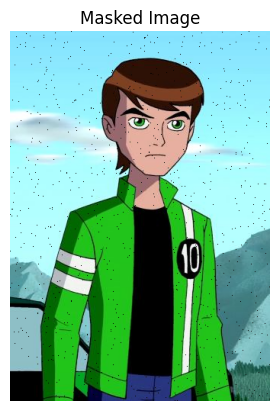

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.kernel_approximation import RBFSampler

# Load image and normalize
img_path = 'ben_10_copy.jpg'  # Update this path as needed
img = torchvision.io.read_image(img_path).float() / 255.0  # Normalize between 0 and 1
img = img.permute(1, 2, 0)  # Change shape to (height, width, channels)

# Step 1: Mask the image
def mask_image(img, num_masked_pixels):
    height, width, _ = img.shape
    mask = np.ones((height, width), dtype=bool)
    masked_indices = np.random.choice(height * width, num_masked_pixels, replace=False)
    mask.flat[masked_indices] = False
    img_copy = img.copy()
    img_copy[~mask] = np.nan  # Set masked pixels to NaN
    return img_copy, mask

masked_image, mask = mask_image(img.numpy(), 900)
#plt.subplot(1, 3, 2)
plt.imshow(np.where(np.isnan(masked_image), np.zeros_like(masked_image), masked_image)) # Show NaNs as black
plt.title("Masked Image")
plt.axis('off')
plt.show()

In [2]:
print(masked_image.shape)

(485, 341, 3)


In [3]:
def prepare_data(masked_image):
    height, width, _ = masked_image.shape
    known_indices = np.argwhere(~np.isnan(masked_image))
    known_values = masked_image[~np.isnan(masked_image)].reshape(-1, 3)

    # Create coordinate map for known pixels
    X_known = known_indices.astype(float)

    return X_known, known_values

X_known, y_known = prepare_data(masked_image)

In [4]:
from sklearn.kernel_approximation import RBFSampler

def create_rff_features(X, num_features, sigma):
    # Set a random state to the sampler for repoducibility
    rff = RBFSampler(n_components = num_features, gamma = 1 / (2 * sigma**2), random_state = 13)
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype = torch.float32)

X_rff = create_rff_features(X_known, 900, 3)

In [5]:
# Debugging - Print shapes before fitting the model
print(f"Shape of RFF features: {X_rff.shape}")
print(f"Shape of known values: {y_known.shape}")

Shape of RFF features: torch.Size([493455, 900])
Shape of known values: (164485, 3)


In [6]:
# Check if lengths are consistent before fitting the model
if len(X_rff) != len(y_known):
    print("Warning: The number of samples in RFF features and known values do not match!")

    # Aligning shapes by truncating y_known if necessary (this is just a workaround)
    min_length = min(len(X_rff), len(y_known))

    X_rff = X_rff[:min_length]
    y_known = y_known[:min_length]

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        Y = torch.tensor(Y, dtype=torch.float32)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

net = LinearModel(X_rff.shape[1], 3)    #same as 2, 3 only


train(net, 0.005, X_rff, y_known, 2500)

Epoch 0 loss: 0.426580


C:\Users\abhir\AppData\Local\Temp\ipykernel_11616\753419702.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Y = torch.tensor(Y, dtype=torch.float32)


Epoch 100 loss: 0.109265
Epoch 200 loss: 0.072289
Epoch 300 loss: 0.063458
Epoch 400 loss: 0.058118
Epoch 500 loss: 0.054146
Epoch 600 loss: 0.051037
Epoch 700 loss: 0.048560
Epoch 800 loss: 0.046579
Epoch 900 loss: 0.044996
Epoch 1000 loss: 0.043735
Epoch 1100 loss: 0.042733
Epoch 1200 loss: 0.041937
Epoch 1300 loss: 0.041305
Epoch 1400 loss: 0.040803
Epoch 1500 loss: 0.040402
Epoch 1600 loss: 0.040080
Epoch 1700 loss: 0.039820
Epoch 1800 loss: 0.039609
Epoch 1900 loss: 0.039433
Epoch 2000 loss: 0.039287
Epoch 2100 loss: 0.039163
Epoch 2200 loss: 0.039056
Epoch 2300 loss: 0.038963
Epoch 2400 loss: 0.038881


0.03880924731492996

In [8]:
# Step 4: Predict missing pixels using RFF features for masked locations
missing_indices = np.argwhere(np.isnan(masked_image))
X_missing_rff = create_rff_features(missing_indices.astype(float), 900, 3)

In [9]:
predicted_values = net(X_missing_rff)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


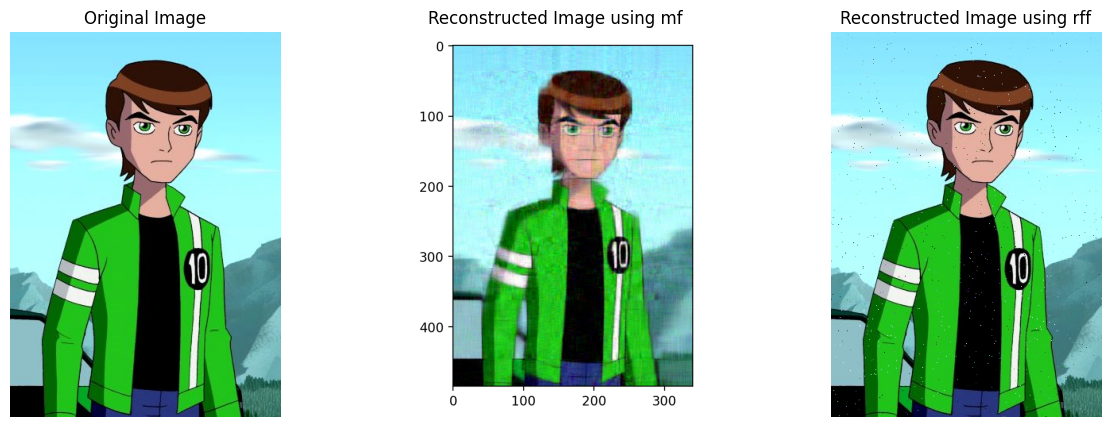

In [11]:
# Step 5: Reconstruct image with predicted values
reconstructed_image = masked_image.copy()
reconstructed_image[missing_indices[:, 0], missing_indices[:, 1]] = predicted_values.detach().numpy()
mf_reconstructed_img = torchvision.io.read_image('results/mf_reconstructed_img.png')
mf_reconstructed_img = mf_reconstructed_img.permute(1,2,0)
# Step 6: Visualize results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(mf_reconstructed_img)
plt.title("Reconstructed Image using mf")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(reconstructed_image)
plt.title("Reconstructed Image using rff")
plt.axis('off')

plt.show()

In [12]:
def compute_rmse(tensor1, tensor2):
    # Convert NumPy arrays to PyTorch tensors
    if not isinstance(tensor1, torch.Tensor):
        tensor1 = torch.from_numpy(tensor1)
    if not isinstance(tensor2, torch.Tensor):
        tensor2 = torch.from_numpy(tensor2)

    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"

    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(tensor1, tensor2, max_pixel_value=1.0):
    # Convert NumPy arrays to PyTorch tensors
    if not isinstance(tensor1, torch.Tensor):
        tensor1 = torch.from_numpy(tensor1)
    if not isinstance(tensor2, torch.Tensor):
        tensor2 = torch.from_numpy(tensor2)

    mse = torch.mean((tensor1 - tensor2) ** 2)
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse)
    return psnr.item()

rmse = compute_rmse(reconstructed_image, img)
psnr = compute_psnr(reconstructed_image, img)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr}")

RMSE: 0.035761211067438126
PSNR: 28.93175506591797
